## **Setup and Data Loading**

In [2]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Importing libraries required to load the data

import zipfile
import os
import cv2

import random


from PIL import Image

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from google.colab.patches import cv2_imshow

from numpy import expand_dims



**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [11]:
#Storing the path of the data file from the Google drive
#/content/cell_images
path = '/content/drive/MyDrive/MIT-Capstone/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

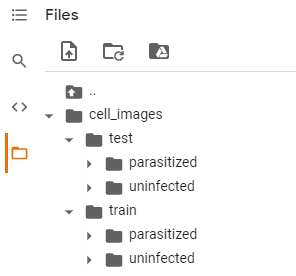

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [12]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store all the training images after they are converted to NumPy arrays
train_images = []
#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

#Empty list to store all the test images after they are converted to NumPy arrays
test_images = []
#Empty list to store the test labels (0 - uninfected, 1 - parasitized)
test_labels = []

#creating a couple of more lists to distinguish parasitized and uninfected training images for visualization purposes (data analysis)
train_images_parasitized = []
train_images_uninfected = []



#creating a couple of more lists to distinguish parasitized and uninfected training labels for data analysis
train_labels_parasitized = []
train_labels_uninfected = []

#creating a two lists to distinguish parasitized and uninfected training images from test data set
test_images_parasitized = []
test_images_uninfected = []

#Set for storing unique image sizes on training and test set
train_image_sizes = set()
test_image_sizes = set()



In [13]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Storing original image size for analysis (before resizing)
            #w, l = image.size
            train_image_sizes.add(image.size)

            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
                train_images_parasitized.append(np.array(image))
            else:
                train_labels.append(0)
                train_images_uninfected.append(np.array(image))
                

        except Exception as e:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)



In [14]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Storing original image size for analysis (before resizing)
            test_image_sizes.add(image.size)            

            #Resizing each image to (224,224)
            image = image.resize((SIZE, SIZE))
           
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
                test_images_parasitized.append(np.array(image))
            else:
                test_labels.append(0)
                test_images_uninfected.append(np.array(image))
        except Exception as e:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)



# **Data Exploration**

In [8]:
#Data Exploration

#Count the number of images in the training and test set
len(train_images), len(test_images)


(24958, 2600)

In [9]:
#Shape of the images - we want to make sure they are a 4D array for later data processing
# We also want to confirm images have been resizes and determine number of channels
train_images.shape, test_images.shape


((24958, 64, 64, 3), (2600, 64, 64, 3))

In [10]:
#Shape of the labels
train_labels.shape, test_labels.shape

((24958,), (2600,))

In [11]:
#Analyze the number of unique image sizes on the original train and test set (before resizing)
len(train_image_sizes), len(test_image_sizes)

(1567, 695)

In [12]:
#Analyzing class balance
#Num of parasitized (1) and uninfected (0) images on training set
len(train_images_parasitized), len(train_images_uninfected)

(12479, 12479)

In [13]:
#Num of parasitized (1) and uninfected (0) images on test set
len(test_images_parasitized), len(test_images_uninfected)

(1300, 1300)

Sample train images - parasitized


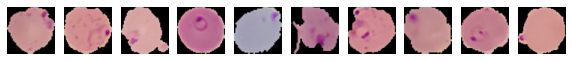

Sample train images - uninfected


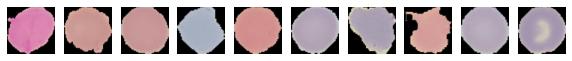

In [14]:
#Defining a function that displays n images and their labels from a given folder
def visualize_image(img_folder, n):
  plt.figure(figsize=(n, 1))
  for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(img_folder[i], ) # write the function to visualize images
    plt.axis('off')
  plt.show()

#Visualizing first 10 images from train data set
print('Sample train images - parasitized')
visualize_image(train_images_parasitized, 10)
print('Sample train images - uninfected')
visualize_image(train_images_uninfected,  10)

# **Data Preparation**

In [49]:
#Normalizing data
train_images_normalized = (train_images/255.0).astype(np.float32)
test_images_normalized = (test_images/255.0).astype(np.float32)

In [50]:
# One hot encode output
train_labels_encoded = to_categorical(train_labels)
test_labels_encoded = to_categorical(test_labels)

# no.of classes
test_labels

array([1, 1, 1, ..., 0, 0, 0])

**Model Building**

# **Model 1 - Baseline CNN**



In [17]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [18]:
# Get shape info for model building 

print('Training set:', train_images.shape, train_labels.shape)
print('Test set:', test_images.shape, test_labels.shape)

Training set: (24958, 64, 64, 3) (24958,)
Test set: (2600, 64, 64, 3) (2600,)


In [19]:
#Importing losses and optimizers modules
from tensorflow.keras import losses
from tensorflow.keras import optimizers

#Define the function
def nn_model_1():
    model = Sequential() 

    # adding first conv layer with 16 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(64, 64, 3)))

    # adding leaky relu activation function with negative slope of 0.1
    model.add(LeakyReLU(0.1))

    # adding second conv layer with 32 filters and with kernel size 3x3
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))

    # adding leaky relu activation function with negative slope of 0.1
    model.add(LeakyReLU(0.1))

    #Flatten the output from the previous layer
    model.add(Flatten())
    
    #Add a dense layer with 32 nodes
    model.add(Dense(32))
    
    #Add a LeakyRelu layer with slope equal to 0.1
    model.add(LeakyReLU(0.1))

    #Output layer with softmax activation and number of nodes equal to the number of classes
    model.add(Dense(2, activation='softmax'))
    
    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate=0.001)
    
    #compile the model
    model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [20]:
#Build the model

model1 = nn_model_1()

In [21]:
#Print first model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4194336   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0

In [22]:
#Fit the model
history_model_1 = model1.fit(train_images_normalized, 
                    train_labels_encoded,
                    validation_split=0.2, 
                    batch_size=128,
                    epochs=20, 
                    verbose=1)

Epoch 1/20
156/156 [==============================] - 17s 14ms/step - loss: 0.7688 - accuracy: 0.6514 - val_loss: 1.1453 - val_accuracy: 0.2416
Epoch 2/20
156/156 [==============================] - 2s 13ms/step - loss: 0.4842 - accuracy: 0.7714 - val_loss: 0.4756 - val_accuracy: 0.8129
Epoch 3/20
156/156 [==============================] - 2s 13ms/step - loss: 0.3137 - accuracy: 0.8756 - val_loss: 0.2551 - val_accuracy: 0.8960
Epoch 4/20
156/156 [==============================] - 2s 13ms/step - loss: 0.2248 - accuracy: 0.9163 - val_loss: 0.3423 - val_accuracy: 0.8772
Epoch 5/20
156/156 [==============================] - 2s 13ms/step - loss: 0.1938 - accuracy: 0.9266 - val_loss: 0.3890 - val_accuracy: 0.8552
Epoch 6/20
156/156 [==============================] - 2s 13ms/step - loss: 0.1726 - accuracy: 0.9348 - val_loss: 0.2181 - val_accuracy: 0.9161
Epoch 7/20
156/156 [==============================] - 2s 13ms/step - loss: 0.1478 - accuracy: 0.9454 - val_loss: 0.2361 - val_accuracy: 0.922

**Plotting the validation and training accuracies**

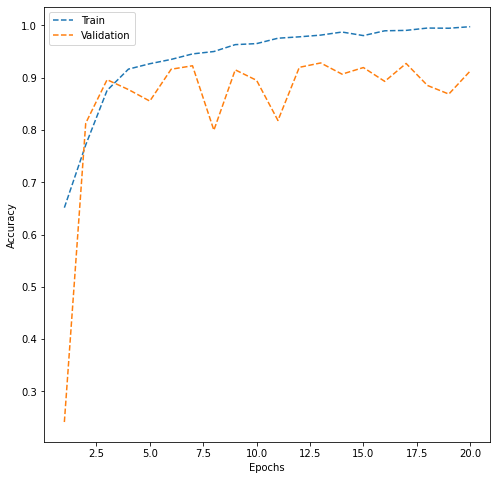

In [23]:
# plotting the accuracies
dict_hist = history_model_1.history
list_ep = [i for i in range(1,21)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_hist['accuracy'],ls = '--', label = 'accuracy')
plt.plot(list_ep,dict_hist['val_accuracy'],ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Predictions on test data**

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1300
           1       0.91      0.89      0.90      1300

    accuracy                           0.90      2600
   macro avg       0.90      0.90      0.90      2600
weighted avg       0.90      0.90      0.90      2600



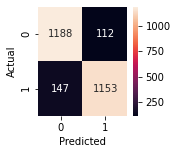

In [24]:
#Model 1 Making predictions on the test data for model 1
y_pred_test1 = model1.predict(test_images_normalized)

#Converting probabilities to class labels
y_pred_test_classes1 = np.argmax(y_pred_test1, axis=1)

#Calculating the probability of the predicted class
y_pred_test_max_probas1 = np.max(y_pred_test1, axis=1)

#Printing the classification report
print(classification_report(test_labels, y_pred_test_classes1))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(test_labels, y_pred_test_classes1)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# **Model 2 - Hyperparameter tunning**


In [25]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [26]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [27]:
#Importing losses and optimizers modules
from tensorflow.keras import losses
from tensorflow.keras import optimizers

#Define the function
def cnn_model_2():
    model = Sequential() 

    # adding first conv layer with 16 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(64, 64, 3)))

    # adding leaky relu activation function with negative slope of 0.1
    model.add(LeakyReLU(0.1))

    # adding second conv layer with 32 filters and with kernel size 3x3
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))

    # adding leaky relu activation function with negative slope of 0.1
    model.add(LeakyReLU(0.1))

    #A max-pooling layer with a pool size of 2x2
    model.add(MaxPool2D(pool_size=(2, 2)))

    # adding dropout to randomly switch off 25% of the network to reduce overfitting
    model.add(Dropout(0.25))
    
    #Add a BatchNormalization layer
    #model.add(BatchNormalization())

    #third Convolutional layer with 32 filters and kernel size of 3x3 with 'same' padding
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))

    #Add a LeakyRelu layer with slope equal to 0.1
    model.add(LeakyReLU(0.1))

    #fourth Convolutional layer with 32 filters and kernel size of 3x3 with 'same' padding
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))

    #Add a LeakyRelu layer with slope equal to 0.1
    model.add(LeakyReLU(0.1))

    #A max-pooling layer with a pool size of 2x2
    model.add(MaxPool2D(pool_size=(2, 2)))

    #Add a BatchNormalization layer
    model.add(BatchNormalization())

    #Flatten the output from the previous layer
    model.add(Flatten())
    
    #Add a dense layer with 32 nodes
    model.add(Dense(32))
    
    #Add a LeakyRelu layer with slope equal to 0.1
    model.add(LeakyReLU(0.1))

    #Add a dropout layer with rate equal to 0.5
    model.add(Dropout(0.5))

    #Output layer with softmax activation and number of nodes equal to the number of classes
    model.add(Dense(2, activation='softmax'))
    
    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate=0.001)
    
    #compile the model
    model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [28]:
#Build the model
model2 = cnn_model_2()

In [29]:
#Print the model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9

In [30]:
#Fit the model
history_model_2 = model2.fit(train_images_normalized, 
                    train_labels_encoded,
                    validation_split=0.2, 
                    batch_size=128,
                    epochs=20, 
                    verbose=1)

Epoch 1/20
156/156 [==============================] - 3s 19ms/step - loss: 0.6412 - accuracy: 0.6724 - val_loss: 0.9951 - val_accuracy: 0.0000e+00
Epoch 2/20
156/156 [==============================] - 3s 18ms/step - loss: 0.3639 - accuracy: 0.8391 - val_loss: 1.6391 - val_accuracy: 0.0000e+00
Epoch 3/20
156/156 [==============================] - 3s 18ms/step - loss: 0.1742 - accuracy: 0.9412 - val_loss: 1.0626 - val_accuracy: 0.0000e+00
Epoch 4/20
156/156 [==============================] - 3s 18ms/step - loss: 0.1575 - accuracy: 0.9454 - val_loss: 0.3114 - val_accuracy: 0.9491
Epoch 5/20
156/156 [==============================] - 3s 17ms/step - loss: 0.1452 - accuracy: 0.9517 - val_loss: 0.2549 - val_accuracy: 0.9643
Epoch 6/20
156/156 [==============================] - 3s 18ms/step - loss: 0.1392 - accuracy: 0.9536 - val_loss: 0.1889 - val_accuracy: 0.9675
Epoch 7/20
156/156 [==============================] - 3s 18ms/step - loss: 0.1284 - accuracy: 0.9559 - val_loss: 0.2108 - val_accu

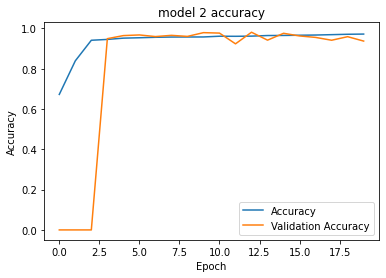

In [31]:
# plotting the accuracies

import matplotlib.pyplot as plt
plt.plot(history_model_2.history["accuracy"])
plt.plot(history_model_2.history['val_accuracy'])
#plt.plot(history_model_2.history['loss'])
#plt.plot(history_model_2.history['val_loss'])
plt.title("model 2 accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

**Predictions on Test Data**

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



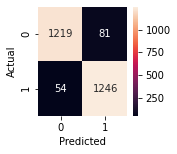

In [32]:
#Model 2 Making predictions on the test data for model 2
y_pred_test2 = model2.predict(test_images_normalized)

#Converting probabilities to class labels
y_pred_test_classes2 = np.argmax(y_pred_test2, axis=1)

#Calculating the probability of the predicted class
y_pred_test_max_probas2 = np.max(y_pred_test2, axis=1)

#Printing the classification report
print(classification_report(test_labels, y_pred_test_classes2))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(test_labels, y_pred_test_classes2)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# **Model 3 - VGG16 architecture with reusable weights**


In [40]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [41]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [42]:
#Importing losses and optimizers modules
from tensorflow.keras import losses
from tensorflow.keras import optimizers

#Define VGG model
def cnn_model_3_VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    #softmax
    #model.add(Dense(2, activation='sigmoid', name='output'))
    model.add(Dense(2, activation='softmax', name='output'))
    return model

In [43]:
#Build the model
model3 = cnn_model_3_VGG16()

In [44]:
#Print the model summary
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2

In [45]:
#call model and pass input as model and output as the last convo block
Vgg16 = Model(inputs=model3.input, outputs=model3.get_layer('vgg16').output)


In [46]:
#Load pre trained weights
Vgg16.load_weights("/content/drive/MyDrive/MIT-Capstone/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")


In [47]:
opt = SGD(learning_rate=1e-4, momentum=0.9)
model3.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

#Optional parameters to stop early once we observe a well performing model. 
#In local environments, VGG-16 can take several hours to train if not using GPU!.
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

#Optional parameters to stop and save best model
mc = ModelCheckpoint('/content/drive/MyDrive/MIT-Capstone/best_model3.h5', monitor='val_accuracy', mode='max', save_best_only=True)


In [53]:
#Fiting model 3
history_model_3 = model3.fit(train_images_normalized, 
                    train_labels_encoded,
                    validation_split=0.2, 
                    batch_size=128,
                   epochs=30, 
                    verbose=1, 
                    callbacks=[mc,es])



Epoch 1/30
156/156 [==============================] - 12s 79ms/step - loss: 0.1009 - accuracy: 0.9648 - val_loss: 0.1514 - val_accuracy: 0.9523
Epoch 2/30
156/156 [==============================] - 12s 79ms/step - loss: 0.0996 - accuracy: 0.9648 - val_loss: 0.1919 - val_accuracy: 0.9371
Epoch 3/30
156/156 [==============================] - 12s 79ms/step - loss: 0.0961 - accuracy: 0.9663 - val_loss: 0.1356 - val_accuracy: 0.9547
Epoch 4/30
156/156 [==============================] - 12s 79ms/step - loss: 0.0947 - accuracy: 0.9660 - val_loss: 0.1690 - val_accuracy: 0.9435
Epoch 5/30
156/156 [==============================] - 12s 79ms/step - loss: 0.0948 - accuracy: 0.9667 - val_loss: 0.1005 - val_accuracy: 0.9663
Epoch 6/30
156/156 [==============================] - 12s 79ms/step - loss: 0.0916 - accuracy: 0.9676 - val_loss: 0.1449 - val_accuracy: 0.9515
Epoch 7/30
156/156 [==============================] - 12s 79ms/step - loss: 0.0886 - accuracy: 0.9686 - val_loss: 0.1870 - val_accuracy:

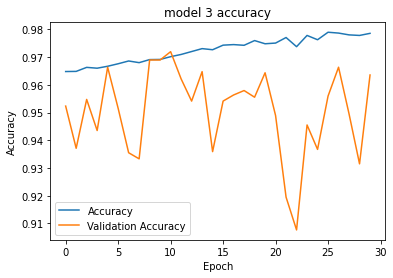

In [54]:
# plotting the accuracies

import matplotlib.pyplot as plt
plt.plot(history_model_3.history["accuracy"])
plt.plot(history_model_3.history['val_accuracy'])
#plt.plot(history_model_3.history['loss'])
#plt.plot(history_model_3.history['val_loss'])
plt.title("model 3 accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1300
           1       0.96      0.96      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



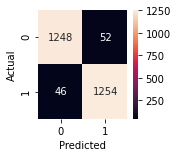

In [55]:
#Model 3 Making predictions on the test data for model 3
y_pred_test3 = model3.predict(test_images_normalized)

#Converting probabilities to class labels
y_pred_test_classes3 = np.argmax(y_pred_test3, axis=1)

#Calculating the probability of the predicted class
y_pred_test_max_probas3 = np.max(y_pred_test3, axis=1)

#Printing the classification report
print(classification_report(test_labels, y_pred_test_classes3))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(test_labels, y_pred_test_classes3)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [44]:
#Save the model as JSON for future inference
model_json = model3.to_json()
with open("/content/drive/MyDrive/MIT-Capstone/model3.json","w") as json_file:
  json_file.write(model_json)

**Predictions on test data**

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1300
           1       0.96      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



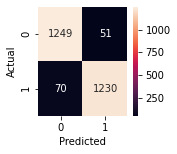

In [45]:
#Model 3 Making predictions on the test data for model 3
y_pred_test3 = model3.predict(test_images_normalized)

#Converting probabilities to class labels
y_pred_test_classes3 = np.argmax(y_pred_test3, axis=1)

#Calculating the probability of the predicted class
y_pred_test_max_probas3 = np.max(y_pred_test3, axis=1)

#Printing the classification report
print(classification_report(test_labels, y_pred_test_classes3))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(test_labels, y_pred_test_classes3)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Visualizing predictions from random images from the test data set**

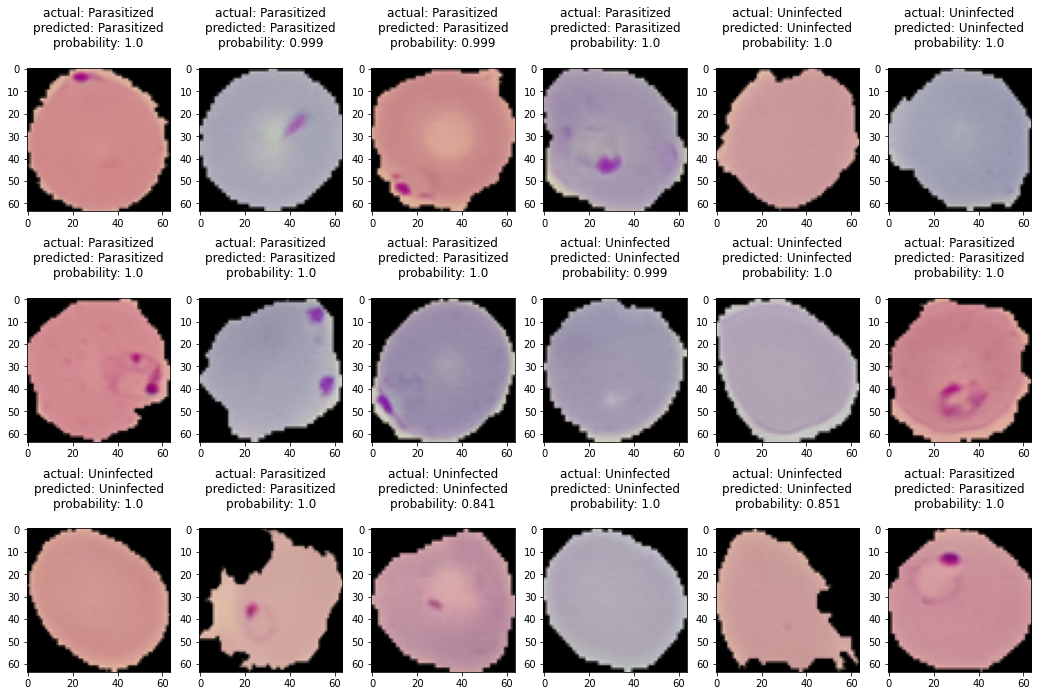

In [46]:
#Visualize predictions from random images from test data set
class_labels = ["Uninfected", "Parasitized"]

rows = 3
cols = 6
fig = plt.figure(figsize=(18, 12))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(test_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(test_images[random_index, :])
        predicted_label = class_labels[y_pred_test_classes3[random_index]]
        predicted_proba = y_pred_test_max_probas3[random_index]
        true_label_value = class_labels[test_labels[random_index]]
        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label_value, predicted_label, predicted_proba
        ))
plt.show()

# **Model 4: VGG architecture with reusable weights and data augmentation**

This is my final model. It builds on top of model 3 (VGG-16 architecture w/reusable weights) but I am augmenting the data set using ImageDataGenerator. This will help expand data set with:

*   Horizontal and vertical shifts
*   Horizontal and vertical flip augmentation
*   Random rotation, brightness and zoom







**Image Augmentation**

Sample image augmentation:

Data augmentation example 1: Zoomed variations for a given image


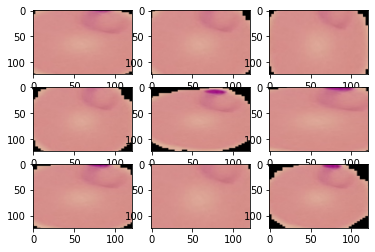

In [16]:
#Displaying a sampled augmented image

#Load a random train image
random_image =  random.choice(os.listdir(train_dir + '/parasitized/'))
img = load_img(train_dir + '/parasitized/' + random_image)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

#Create a zoomed image data augmentation generator
datagen_zoomed = ImageDataGenerator(zoom_range=[0.5,1.0])

#fig = plt.figure(figsize=(18, 12))

# prepare iterator
it = datagen_zoomed.flow(samples, batch_size=1)

print('Data augmentation example 1: Zoomed variations for a given image')

# generate samples and plot
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  #plot raw pixel data
  plt.imshow(image, aspect='auto')
  
# show the figure
plt.show()



Data augmentation example 2: Different brightness variations for a given image


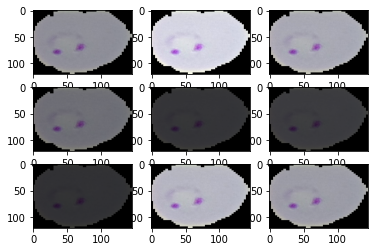

In [17]:
#Create a brightness range image data augmentation generator

#Load a random train image
random_image =  random.choice(os.listdir(train_dir + '/parasitized/'))
img = load_img(train_dir + '/parasitized/' + random_image)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

datagen_brightness = ImageDataGenerator(brightness_range=[0.2,1.0])

#fig = plt.figure(figsize=(18, 12))
#fig = plt.figure(figsize=(18, 12))
# prepare iterator
it = datagen_brightness.flow(samples, batch_size=1)
# generate samples and plot
print('Data augmentation example 2: Different brightness variations for a given image')
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  #plot raw pixel data
  plt.imshow(image, aspect='auto')
  
# show the figure
plt.show()

Data augmentation example 3: Different rotated variations for a given image


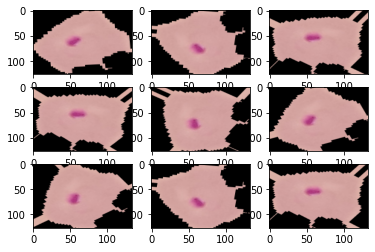

In [18]:
#Create a rotation range image data augmentation generator

#Load a random train image
random_image =  random.choice(os.listdir(train_dir + '/parasitized/'))
img = load_img(train_dir + '/parasitized/' + random_image)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

datagen_rotation = ImageDataGenerator(rotation_range=90)

#fig = plt.figure(figsize=(18, 12))
#fig = plt.figure(figsize=(18, 12))
# prepare iterator
it = datagen_rotation.flow(samples, batch_size=1)
# generate samples and plot
print('Data augmentation example 3: Different rotated variations for a given image')
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  #plot raw pixel data
  plt.imshow(image, aspect='auto')
  
# show the figure
plt.show()

In [19]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

#Re-parsing all images to expand them as we load them in batches

#Empty list to store all the training images after they are converted to NumPy arrays
train_images_augmented = []
#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels_augmented = []


#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    sem = 1 
    count = 0
    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)
            #print(image)
            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))

            if sem > 0:
              #New -> Augmenting original image and adding them all on this loop
              samples = expand_dims(np.array(image), 0)
              datagen = ImageDataGenerator(rotation_range=90, brightness_range=[0.2,1.0], zoom_range=[0.5,1.0])
              it = datagen.flow(samples, batch_size=1)

              #generating 5 variations. Larger number can cause colab to crash as it exhaustes RAM available
              for i in range(5):
                #print('Processing img' + (str(count)))
                count = count +1
                batch = it.next()
                #convert to unsigned integers for viewing
                image_expanded = batch[0]
                train_images_augmented.append(image_expanded)
                #Creating labels for parasitized and uninfected images
                if folder_name=='/parasitized/':
                  train_labels_augmented.append(1)
                else:
                  train_labels_augmented.append(0)

              #Converting images to arrays and appending that array to the empty list defined above
              #print('Processing img' + (str(count)))
              train_images_augmented.append(np.array(image))
              count = count +1

              #Creating labels for parasitized and uninfected images
              if folder_name=='/parasitized/':
                  train_labels_augmented.append(1)
              else:
                  train_labels_augmented.append(0)

              sem = 1
            else:
              break;

        except Exception as e:
            print(e)
            pass       

#Converting lists to arrays
train_images_augmented = np.array(train_images_augmented)
train_labels_augmented = np.array(train_labels_augmented)



cannot identify image file '/content/cell_images/train/parasitized/Thumbs.db'
cannot identify image file '/content/cell_images/train/uninfected/Thumbs.db'


In [20]:
#Size of augmented image set
train_images_augmented.shape, train_labels_augmented.shape

((149748, 64, 64, 3), (149748,))

In [21]:
#Size of original image set
train_images.shape, test_images.shape


((24958, 64, 64, 3), (2600, 64, 64, 3))

**Augmented Data Preparation**

In [22]:
#Normalizing data (only for train data, as test data is not augmented)
train_images_augmented_normalized = train_images_augmented/255.0

# One hot encode output (only for train labels)
train_labels_augmented_encoded = to_categorical(train_labels_augmented)

**Model creation** 

In [23]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [24]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [25]:
#Importing losses and optimizers modules
from tensorflow.keras import losses
from tensorflow.keras import optimizers

#Define VGG model
def cnn_model_4_VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    #softmax
    model.add(Dense(2, activation='softmax', name='output'))
    return model

In [26]:
#Build the model
model4 = cnn_model_4_VGG16()

In [27]:
#Print the model summary
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2

In [28]:
#call model and pass input as model and output as the last convo block
Vgg16 = Model(inputs=model4.input, outputs=model4.get_layer('vgg16').output)


In [29]:
#Load pre trained weights
Vgg16.load_weights("/content/drive/MyDrive/MIT-Capstone/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [30]:
opt = SGD(learning_rate=1e-4, momentum=0.9)
model4.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

#Optional parameters to stop early once we observe a well performing model. 
#In local environments, VGG-16 can take several hours to train if not using GPU!.
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

#Optional parameters to stop and save best model
mc = ModelCheckpoint('/content/drive/MyDrive/MIT-Capstone/best_model4.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [31]:
#Fiting model 4
history_model_4 = model4.fit(train_images_augmented_normalized, 
                    train_labels_augmented_encoded,
                    validation_split=0.2, 
                    batch_size=128,
                   epochs=50, 
                    verbose=1, 
                    callbacks=[mc,es])

Epoch 1/50
936/936 [==============================] - 80s 82ms/step - loss: 0.3535 - accuracy: 0.8316 - val_loss: 0.2418 - val_accuracy: 0.9369
Epoch 2/50
936/936 [==============================] - 74s 79ms/step - loss: 0.2295 - accuracy: 0.9060 - val_loss: 0.3591 - val_accuracy: 0.8756
Epoch 3/50
936/936 [==============================] - 74s 79ms/step - loss: 0.2130 - accuracy: 0.9133 - val_loss: 0.3083 - val_accuracy: 0.8956
Epoch 4/50
936/936 [==============================] - 74s 79ms/step - loss: 0.2020 - accuracy: 0.9176 - val_loss: 0.2357 - val_accuracy: 0.9302
Epoch 5/50
936/936 [==============================] - 74s 79ms/step - loss: 0.1917 - accuracy: 0.9221 - val_loss: 0.1765 - val_accuracy: 0.9470
Epoch 6/50
936/936 [==============================] - 74s 79ms/step - loss: 0.1859 - accuracy: 0.9243 - val_loss: 0.2824 - val_accuracy: 0.9020
Epoch 7/50
936/936 [==============================] - 74s 79ms/step - loss: 0.1809 - accuracy: 0.9268 - val_loss: 0.2753 - val_accuracy:

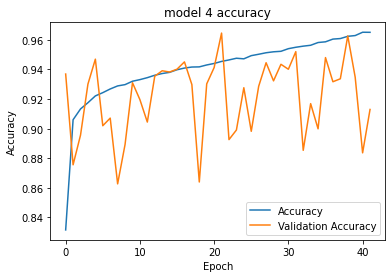

In [32]:
import matplotlib.pyplot as plt
plt.plot(history_model_4.history["accuracy"])
plt.plot(history_model_4.history['val_accuracy'])
#plt.plot(history_model_4.history['loss'])
#plt.plot(history_model_4.history['val_loss'])
plt.title("model 4 accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
#Save the model as JSON for future inference
model_json = model4.to_json()
with open("/content/drive/MyDrive/MIT-Capstone/model4.json","w") as json_file:
  json_file.write(model_json)

**Predictions on test data**


              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1300
           1       0.98      0.90      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



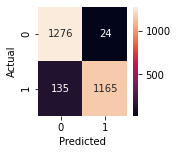

In [34]:
#Model 4 Making predictions on the test data for model 4

#load model
#from keras.models import model_from_json

#json_file = open('/content/drive/MyDrive/MIT-Capstone/model4.json', 'r')
#model_json_c = json_file.read()
#json_file.close()
#model4 = model_from_json(model_json_c)

y_pred_test4 = model4.predict(test_images)

#Converting probabilities to class labels
y_pred_test_classes4 = np.argmax(y_pred_test4, axis=1)

#Calculating the probability of the predicted class
y_pred_test_max_probas4 = np.max(y_pred_test4, axis=1)

#Printing the classification report
print(classification_report(test_labels, y_pred_test_classes4))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(test_labels, y_pred_test_classes4)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Visualizing predictions from random images from the test data set**

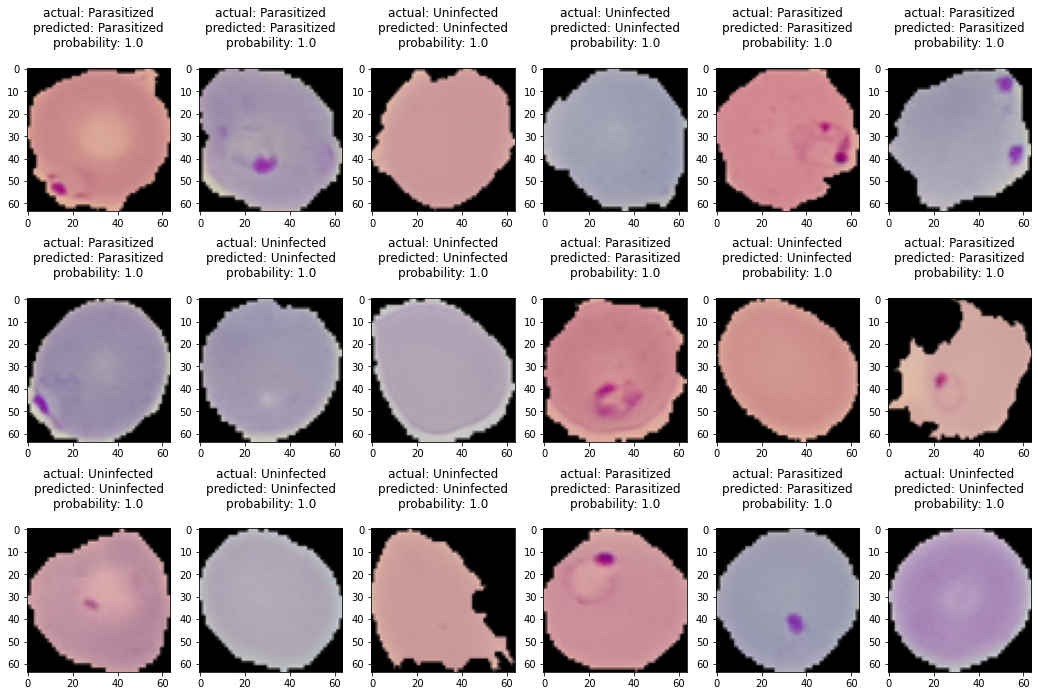

In [37]:
#Visualize predictions from random images from test data set
class_labels = ["Uninfected", "Parasitized"]

rows = 3
cols = 6
fig = plt.figure(figsize=(18, 12))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(test_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(test_images[random_index, :])
        predicted_label = class_labels[y_pred_test_classes4[random_index]]
        predicted_proba = y_pred_test_max_probas4[random_index]
        true_label_value = class_labels[test_labels[random_index]]
        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label_value, predicted_label, predicted_proba
        ))
plt.show()